In this notebook, it is explained how to design your own custom baseline using Oodeel.

## The OODBaseDetector class

The abstraction for OOD baselines is `OODBaseDetector`. It implements high-level methods such as `.score()` or `.fit()` that will be used by the end user. The method `.score()` calls the code for scoring a tensor along with handling type checking and managing iterable structures and batch-wise concatenation. The method `.fit()` instantiates a `FeatureExtractor`, an `Operator` and a `DataHandler` depending on the underlying library of the neural network as an attribute to `OODBaseDetector`. It also calls for the code to fit the OODBaseDetector to some fit data, if needed. 

> **Remark:**
>
> For instance, `DKNN` needs fit data to construct its nearest neighbor structure, while `MLS` does not, since it only returns the maximum output logit as the OOD score.

Basically, all the code that is baseline specific and that performs OOD-related operations is contained in the methods (Type hinting is omitted for conciseness):

In [1]:
def _fit_to_dataset(self, fit_dataset):
    """
    Fits the detector to fit_dataset.
    To be overrided in child classes (if needed)

    Args:
        fit_dataset: dataset to fit the detector on
    """
    raise NotImplementedError()

def _score_tensor(self, inputs):
    """Computes an OOD score for input samples "inputs".
    Method to override with child classes.

    Args:
        inputs: tensor to score

    Raises:
        NotImplementedError: _description_
    """
    raise NotImplementedError()

Therefore, implementing a custom baseline boils down to implementing those two methods.

## Implementing a new baseline

In this section, we implement a new baseline inheriting from `OODBaseDetector`.

We will implement a dummy version of Deep K-Nearest-Neighbors. The method will randomly select `n_basis` vectors from the fit dataset, and score new inputs by computing the distance to their $k$ nearest neighbor with respect to the $L_2$ norm (so $k \ll$ `n_basis`).

Let first instantiate the `__init__` function. You need to pass required `OODBaseDetector` init arguments a argument to `.super().__init__()`. It is the place to init and declare other attributes. Here, these will be `n_basis`, `k`, and `basis_vectors` (the vectors used for computing the distances).

For simplicity, we only use numpy, although we could use tensor operations from pytorch or tensorflow using `Operator`.


In [2]:
def __init__(
    self,
    output_layers_id,
    n_basis: int = 1000,
    k: int = 1,
):
    super().__init__(
        output_layers_id=output_layers_id,
    )

    self.n_basis = n_basis
    self.k = k
    self.basis_vectors = None


Then, you want to implement the `_fit_dataset` method. It has to randomly select vectors from the fitting dataset.


In [3]:
def _fit_to_dataset(self, fit_dataset):
    """
    Constructs the index from ID data "fit_dataset", which will be used for
    nearest neighbor search.

    Args:
        fit_dataset: input dataset (ID) to construct the index with.
    """
    fit_projected = self.feature_extractor.predict(fit_dataset)
    # self.op is the Operator associated with the object. 
    # It is built automatically and you do not have to bother with it.
    fit_projected = self.op.convert_to_numpy(fit_projected) 
    fit_projected = fit_projected.reshape(fit_projected.shape[0], -1)
    
    ind_basis = np.random.choice([i for i in range(len(fit_projected))], replace=False)
    self.basis_vectors = fit_projected[ind_basis]



Then, `_score_tensor` has to be implemented so that each input tensor is properly scored.


In [4]:
def _score_tensor(self, inputs):
    """
    Computes an OOD score for input samples "inputs" based on
    the distance to nearest neighbors in the feature space of self.model

    Args:
        inputs: input samples to score

    Returns:
        scores
    """

    input_projected = self.feature_extractor(inputs)
    input_projected = self.op.convert_to_numpy(input_projected)
    input_projected = input_projected.reshape(input_projected.shape[0], -1)

    scores = []
    for input_p in input_projected:
        distances = np.sqrt(np.sum((self.basis_vectors - input_p)**2))
        score = np.sort(distances)[self.k]
        scores.append(score)      

    return np.array(scores)


Let's wrap up everything. You have to make your new baselines inherit from `OODBaseDetector`, put all the previous methods and that's it!

In [5]:
from oodeel.methods.base import OODBaseDetector
import numpy as np

from IPython.display import clear_output


class DKNN_dummy(OODBaseDetector):
    def __init__(
    self,
    output_layers_id,
    n_basis: int = 1000,
    k: int = 1,
    ):
        super().__init__(
            output_layers_id=output_layers_id,
        )

        self.n_basis = n_basis
        self.k = k
        self.basis_vectors = None

    def _fit_to_dataset(self, fit_dataset):
        """
        Constructs the index from ID data "fit_dataset", which will be used for
        nearest neighbor search.

        Args:
            fit_dataset: input dataset (ID) to construct the index with.
        """
        fit_projected = self.feature_extractor.predict(fit_dataset)
        # self.op is the Operator associated with the object. 
        # It is built automatically and you do not have to bother with it.
        fit_projected = self.op.convert_to_numpy(fit_projected) 
        fit_projected = fit_projected.reshape(fit_projected.shape[0], -1)
        
        ind_basis = np.random.choice([i for i in range(len(fit_projected))], size = (self.n_basis,), replace=False)
        self.basis_vectors = fit_projected[ind_basis]

    def _score_tensor(self, inputs):
        """
        Computes an OOD score for input samples "inputs" based on
        the distance to nearest neighbors in the feature space of self.model

        Args:
            inputs: input samples to score

        Returns:
            scores
        """

        input_projected = self.feature_extractor(inputs)
        input_projected = self.op.convert_to_numpy(input_projected)
        input_projected = input_projected.reshape(input_projected.shape[0], -1)

        scores = []
        for input_p in input_projected:
            distances = np.sqrt(np.sum((self.basis_vectors - input_p)**2, axis=1))
            score = np.sort(distances)[self.k]
            scores.append(score)      

        return np.array(scores)

    @property
    def requires_to_fit_dataset(self) -> bool:
        """
        Whether an OOD detector needs a `fit_dataset` argument in the fit function.

        Returns:
            bool: True if `fit_dataset` is required else False.
        """
        return True

clear_output()

## Testing your baseline

Then, you only have to use your baseline like any other:

First, prepare the data

In [6]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd

In [7]:


from oodeel.datasets import OODDataset
from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores


model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

backend = "tensorflow"

oods_in = OODDataset(
    'mnist', 
    load_kwargs = {"split": "test"}, 
    backend=backend,
)
oods_out = OODDataset(
    'fashion_mnist', 
    load_kwargs = {"split": "test"}, 
    backend=backend,
)
oods_train = OODDataset(
    'mnist', 
    load_kwargs = {"split": "train"}, 
    backend=backend,
)

def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))

batch_size = 128

ds_in = oods_in.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_out = oods_out.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_train = oods_train.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)

clear_output()

Train the model if needed:

In [8]:
from oodeel.utils.tf_training_tools import train_tf_model

model_path_mnist = os.path.join(model_path, "mnist_model_tensorflow.h5")

try:
    model = tf.keras.models.load_model(model_path_mnist)
except OSError:
    train_config = {
        "model": "toy_convnet",
        "input_shape": (28, 28, 1),
        "num_classes": 10,
        "epochs": 5,
        "save_dir": model_path_mnist,
        "validation_data": ds_in #ds_in is actually the test set of MNIST
    }

    model = train_tf_model(ds_train, **train_config) 

And then the OOD part:

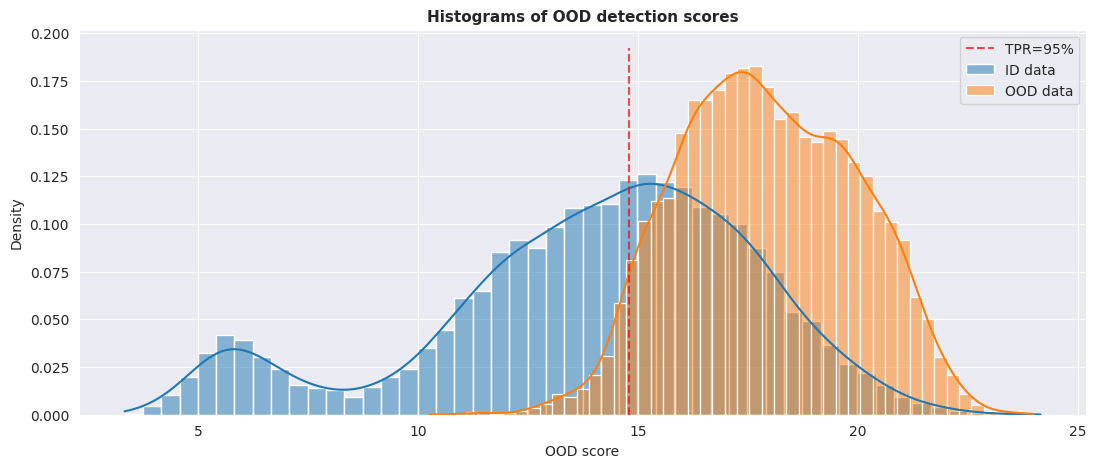

auroc       0.828507
fpr95tpr    0.468900
dtype: float64


In [9]:
dknn_dummy = DKNN_dummy(output_layers_id = [-2])

dknn_dummy.fit(model, ds_train.take(1000))
scores_in = dknn_dummy.score(ds_in)
scores_out = dknn_dummy.score(ds_out)

metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr"], 
    threshold = -7.5 # visually chosen based on the plot
    )

def plot_hist(scores_in, scores_out, bins, log=False):
    if log:
        minim = np.min([np.min(scores_in), np.min(scores_out)])
        scores_in_ = scores_in - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])
        scores_out_ = scores_out - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])
        _, bins = np.histogram(np.concatenate([scores_in_, scores_out_]), bins=30)
        logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
        plt.xscale('log')
        plt.xlabel("score (normalized log axis)")
    else:
        logbins=bins
        scores_in_ = scores_in 
        scores_out_ = scores_out
        plt.xlabel("score")
    plt.hist((scores_out_, scores_in_), bins=logbins, color=("blue", "orange"), label=("ood", "id"))
    plt.legend()
    plt.show()
    
plt.figure(figsize=(13, 5))
plot_ood_scores(scores_in, scores_out)
plt.show()
metrics = pd.Series(metrics)
print(metrics)


The results could be better, but this is up to you!